In [1]:
from distributed import Client

client = Client(n_workers=24)
client

Client Scheduler: tcp://127.0.0.1:54135 Dashboard: http://127.0.0.1:55750/status,Cluster Workers: 24 Cores: 24 Memory: 33.55 GB


In [3]:
import os
import xarray as xr
import pandas as pd
import numpy as np

from cesium import featurize

def featurize_xarray(dataarray):
    
    #stacked = dataarray.stack(z=('x', 'y')).transpose()
    
    times=dataarray.time.values
    
    features_to_use = ["amplitude",
                       #"percent_beyond_1_std",
                       "maximum",
                       #"max_slope",
                       "median",
                       #"median_absolute_deviation",
                       #"percent_close_to_median",
                       "minimum",
                       #"skew",
                       "std",
                       "weighted_average"]
    
    result = xr.apply_ufunc(featurize_ufunc, dataarray,
                            input_core_dims=[['time']],
                            output_core_dims=[['features']],
                            exclude_dims=frozenset(['time']),
                            kwargs={'times': times,
                                    'features_to_use': features_to_use},
                            dask='parallelized',
                            output_dtypes=[np.float64],
                            output_sizes={'features':len(features_to_use)})
    
    result['features'] = ('features', pd.Index(features_to_use))
    
    return result.to_dataset(dim='features')

def featurize_ufunc(da, times, features_to_use):
    
    times_rep = np.repeat(times, da.shape[0]*da.shape[1])
    
    times_rep = times_rep.reshape(times.shape[0], da.shape[0]*da.shape[1]).transpose()
    
    vals_reshaped = da.reshape(da.shape[0]*da.shape[1],times.shape[0])
    
    fset_cesium = featurize.featurize_time_series(times=times_rep,
                                                  values=vals_reshaped,
                                                  errors=None,
                                                  features_to_use=features_to_use)
    
    feat_set = fset_cesium.stack(level=-1).reset_index()[features_to_use]
    
    return feat_set.values.reshape(da.shape[0],da.shape[1],len(features_to_use))


In [9]:
vv = xr.open_dataset(os.environ["WIN_SVR_DATA"]+"Saldana/vars/rad_VV.nc", chunks={'x':750,'y':750}).sortby('time')

In [10]:
vv

<xarray.Dataset>
Dimensions:  (time: 23, x: 2976, y: 3630)
Coordinates:
  * y        (y) float64 4.485e+05 4.485e+05 4.485e+05 4.485e+05 4.485e+05 ...
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * time     (time) datetime64[ns] 2015-06-12 2015-06-19 2015-07-13 ...
Data variables:
    VV       (time, y, x) float32 dask.array<shape=(23, 3630, 2976), chunksize=(23, 750, 750)>

### Test

We start by computing a small part of the dataset for testing.

In [12]:
test = vv.VV.chunk({'x':100,'y':100}).isel(x=slice(1000,1500),y=slice(1000,1500))

In [21]:
small = featurize_xarray(test)

In [22]:
computed = small.compute()
computed

<xarray.Dataset>
Dimensions:           (x: 500, y: 500)
Coordinates:
  * y                 (y) float64 4.385e+05 4.385e+05 4.385e+05 4.385e+05 ...
  * x                 (x) float64 4.989e+05 4.989e+05 4.989e+05 4.989e+05 ...
Data variables:
    amplitude         (y, x) float64 4.332 4.067 3.531 3.062 3.468 2.593 ...
    maximum           (y, x) float64 -9.64 -10.04 -10.33 -9.695 -8.019 ...
    median            (y, x) float64 -15.27 -14.83 -14.41 -13.42 -12.17 ...
    minimum           (y, x) float64 -18.3 -18.17 -17.4 -15.82 -14.96 -13.35 ...
    std               (y, x) float64 2.149 1.979 1.776 1.566 1.98 1.619 ...
    weighted_average  (y, x) float64 -14.94 -14.62 -14.06 -13.24 -12.18 ...

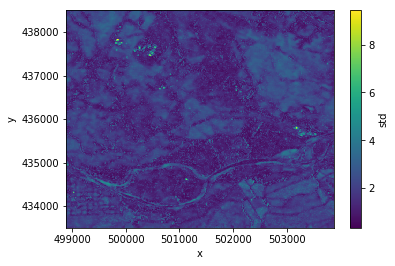

In [20]:
computed['std'].plot()

### Complete dataset

In [11]:
features = featurize_xarray(vv.VV)

In [12]:
features

<xarray.Dataset>
Dimensions:           (x: 2976, y: 3630)
Coordinates:
  * y                 (y) float64 4.485e+05 4.485e+05 4.485e+05 4.485e+05 ...
  * x                 (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
Data variables:
    amplitude         (y, x) float64 dask.array<shape=(3630, 2976), chunksize=(750, 750)>
    maximum           (y, x) float64 dask.array<shape=(3630, 2976), chunksize=(750, 750)>
    median            (y, x) float64 dask.array<shape=(3630, 2976), chunksize=(750, 750)>
    minimum           (y, x) float64 dask.array<shape=(3630, 2976), chunksize=(750, 750)>
    std               (y, x) float64 dask.array<shape=(3630, 2976), chunksize=(750, 750)>
    weighted_average  (y, x) float64 dask.array<shape=(3630, 2976), chunksize=(750, 750)>

In [13]:
features.to_netcdf(os.environ["WIN_SVR_DATA"]+"Saldana/features/VV_feat.nc")

In [1]:
saldana_VV_feat = xr.open_dataset(os.environ["WIN_SVR_DATA"]+"Saldana/features/VV_feat.nc")

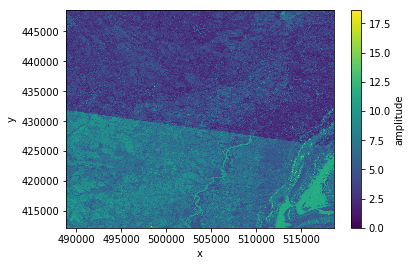

In [17]:
saldana_VV_feat["amplitude"].plot()

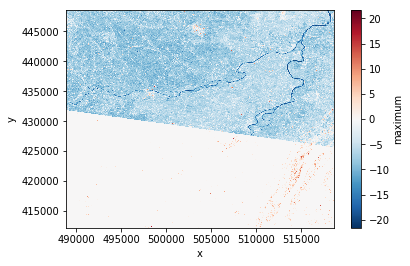

In [19]:
saldana_VV_feat["maximum"].plot()

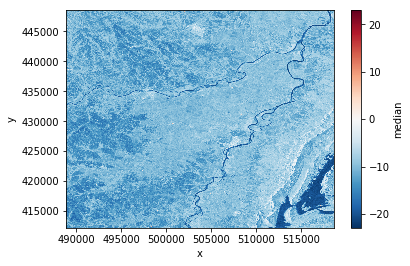

In [3]:
saldana_VV_feat["median"].plot()

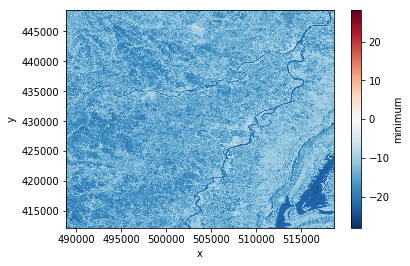

In [6]:
saldana_VV_feat["minimum"].plot()

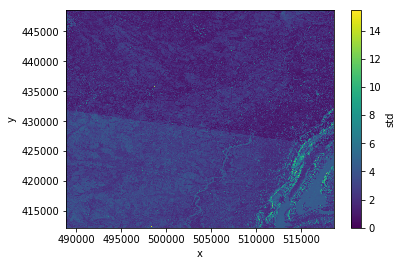

In [4]:
saldana_VV_feat["std"].plot()

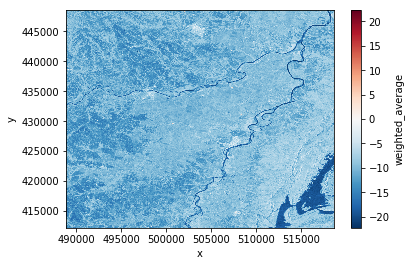

In [5]:
saldana_VV_feat["weighted_average"].plot()